## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from collections import deque
from multiprocessing import Pool
from random import shuffle

/home/vikash/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

* Images for training are present in folders vehicles and non-vehicles as provided in the lectures.

Number of car images:  8792
Number of not-car images:  8968


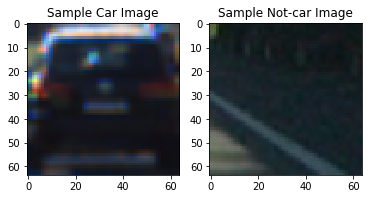

In [130]:
# Read all vehicles from folders recursively
vehicle_images = glob.glob('vehicles/*/*.png',recursive=True)
cars = []
notcars = []
for image in vehicle_images:
        cars.append(image)

#Read all non-vehicles recursively
non_vehicle_images = glob.glob('non-vehicles/*/*.png',recursive=True)
for image in non_vehicle_images:
        notcars.append(image)


#Shuffle input
shuffle(cars)
shuffle(notcars)

print('Number of car images: ', len(cars))
print('Number of not-car images: ', len(notcars))

#Random car and non-car image
car_index = np.random.randint(0, len(cars))
notcar_index = np.random.randint(0, len(notcars))
    
# Read images
car_image = mpimg.imread(cars[car_index])
notcar_image = mpimg.imread(notcars[notcar_index])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Sample Not-car Image')
plt.show()


## Feature Extraction

Feature Extraction methods:
* Color histogram features
* Binned color features
* Histogram of Oriented Gradients (HOG)

In [134]:
#Conversion function from RGB to other formats
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# This function computes color histogram features
def color_hist(img, nbins=32,vis=False):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
   
    if vis:        
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2    
        # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    else:
         # Return the individual histograms, bin_centers and feature vector
        return hist_features

# This function computes binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
# This function returns HOG features and visualization
# orient: Number of orientation bins
# pix_per_cell: (2-tuple, (int, int)). Size of a cell (in pixels).
# cell_per_block: (2-tuple, (int, int)). Number of cells in each block.
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Test feature extraction  images

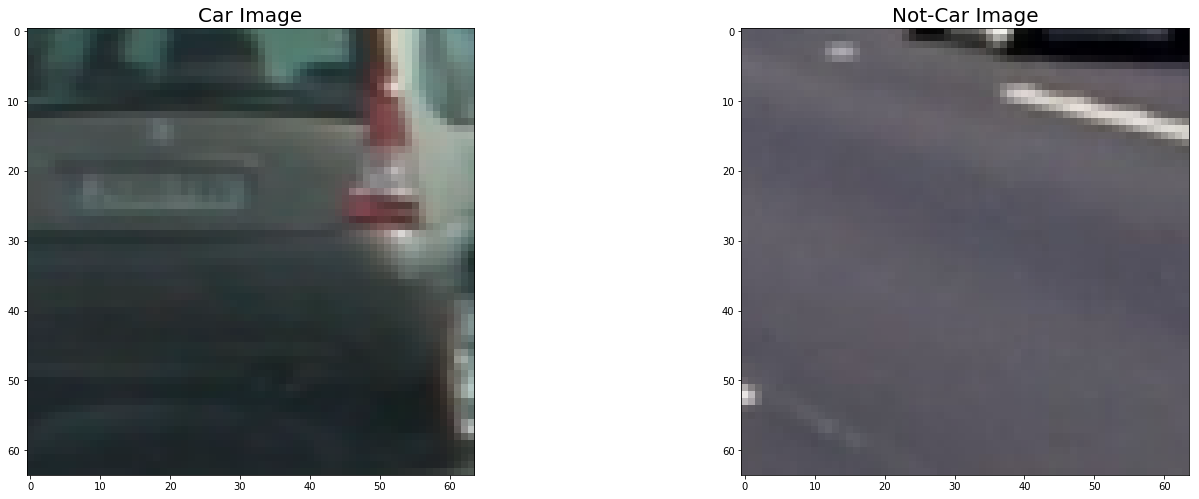

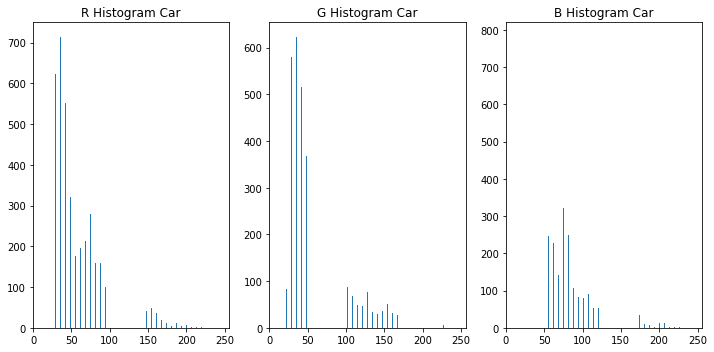

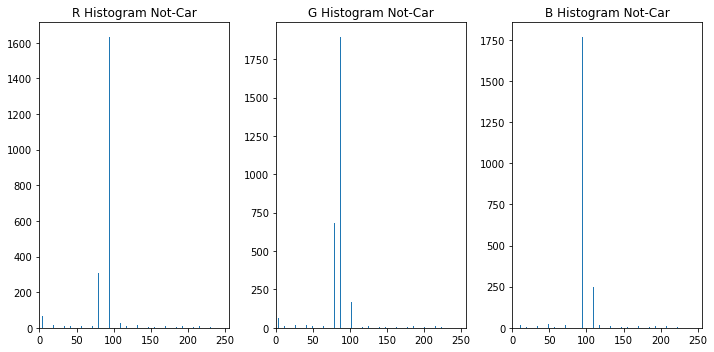

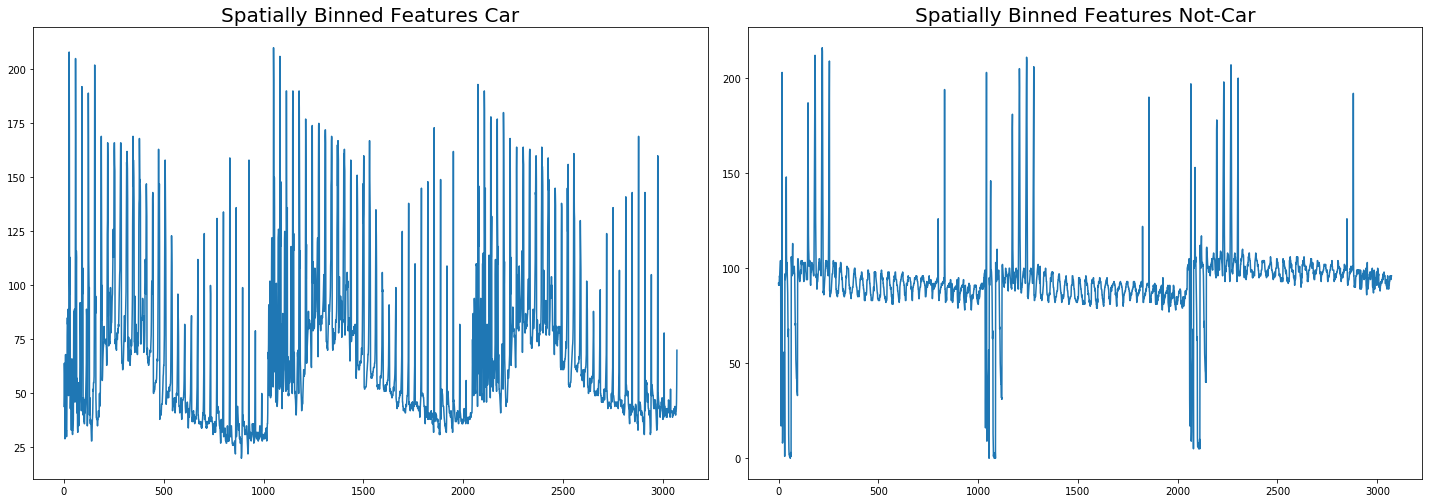

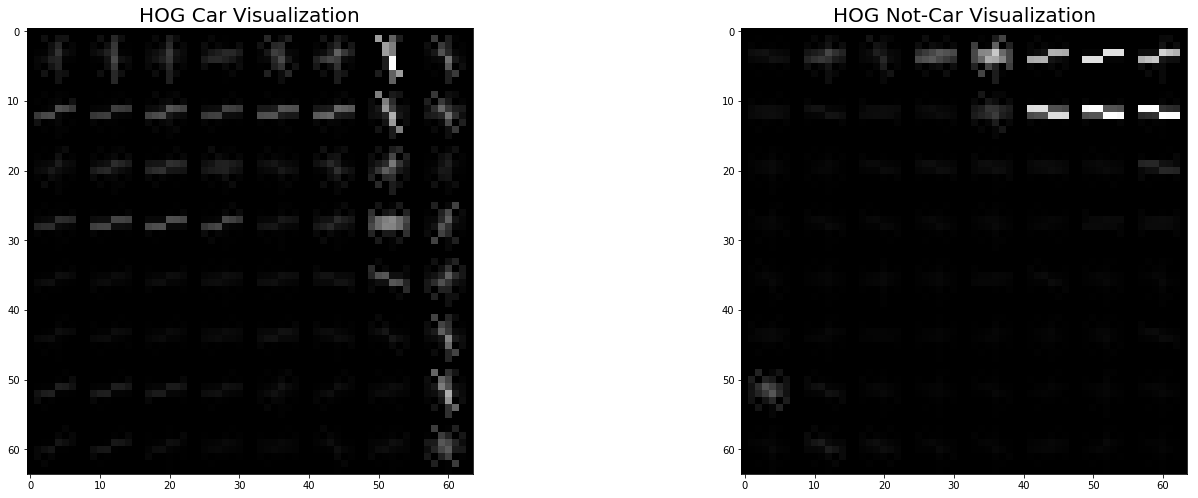

In [166]:
#Random car and non-car image
car_index = np.random.randint(0, len(cars))
notcar_index = np.random.randint(0, len(notcars))
    
# Read images
car_image = mpimg.imread(cars[car_index])
notcar_image = mpimg.imread(notcars[notcar_index])

# Compute color histogram features
car_image = np.uint8(car_image*255)
notcar_image = np.uint8(notcar_image*255)
car_rh, car_gh, car_bh, car_bincen, car_feature_vec = color_hist(car_image, vis=True)
not_car_rh, not_car_gh, not_car_bh, not_car_bincen, not_car_feature_vec = color_hist(notcar_image, 
                                                                        vis=True)
# Compute spatially binned features
car_bin_spatial = bin_spatial(car_image)
not_car_bin_spatial = bin_spatial(notcar_image)

#Convert to gray scale
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

# Get the HOG features and visualization
car_hog_features, car_hog_image = get_hog_features(car_gray, orient, pix_per_cell, 
                                                   cell_per_block, vis=True, 
                                                   feature_vec=False)
not_car_hog_features, not_car_hog_image = get_hog_features(notcar_gray, orient, 
                                                           pix_per_cell, cell_per_block, 
                                                           vis=True, feature_vec=False)

# Plot
fig = plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(car_image)
plt.title('Car Image', fontsize=20)
plt.subplot(322)
plt.imshow(notcar_image)
plt.title('Not-Car Image', fontsize=20)
plt.savefig('output_images/car_notcar.png')
fig.tight_layout()
plt.show()


fig = plt.figure(figsize=(10,5))
plt.subplot(131)
plt.bar(car_bincen, car_rh[0])
plt.xlim(0, 256)
plt.title('R Histogram Car')
plt.subplot(132)
plt.bar(car_bincen, car_gh[0])
plt.xlim(0, 256)
plt.title('G Histogram Car')
plt.subplot(133)
plt.bar(car_bincen, car_bh[0])
plt.xlim(0, 256)
plt.title('B Histogram Car')
plt.savefig('output_images/car_histogram.png')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,5))
plt.subplot(131)
plt.bar(not_car_bincen, not_car_rh[0])
plt.xlim(0, 256)
plt.title('R Histogram Not-Car')
plt.subplot(132)
plt.bar(not_car_bincen, not_car_gh[0])
plt.xlim(0, 256)
plt.title('G Histogram Not-Car')
plt.subplot(133)
plt.bar(not_car_bincen, not_car_bh[0])
plt.xlim(0, 256)
plt.title('B Histogram Not-Car')
plt.savefig('output_images/not_car_histogram.png')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
plt.subplot(323)
plt.plot(car_bin_spatial)
plt.title('Spatially Binned Features Car', fontsize=20)
plt.subplot(324)
plt.plot(not_car_bin_spatial)
plt.title('Spatially Binned Features Not-Car', fontsize=20)
plt.savefig('output_images/car_notcar_spatial.png')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
plt.subplot(325)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG Car Visualization', fontsize=20)
plt.subplot(326)
plt.imshow(not_car_hog_image, cmap='gray')
plt.title('HOG Not-Car Visualization', fontsize=20)
plt.savefig('output_images/car_notcar_hog.png')
fig.tight_layout()
plt.show()


## Extract and combine all features

In [ ]:
#This function extracts features from single image
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train a linear Support Vector Machine (SVM) classifier

* Initialize data
* Prepare data
* Extract features from list of images
* Train a classifier to detect cars

In [141]:
### The following parameters were chosen based on grid search
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
svm_C=100 # Linear SVM C parameter

#Extract all features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

t=time.time()
# Use a linear SVC 
svc =LinearSVC(C=svm_C) 
# Check the training time for the SVC
#clf = GridSearchCV(svc, parameters) 

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
11.42 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.991


## Sliding Window Implementation

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Hog Sub-sampling Window Search

In [3]:
# find_cars is able to extract features & make predictions
# find_cars only has to extract hog features once and then can be 
# sub-sampled to get all of its overlaying windows
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step=2):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    boxes = []
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
   
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),
                                 (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes,draw_img

# Take a list of boxes, and add heat to the heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Apply a threshold to the heatmap to remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw the labeled boxes in an image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Test Window Search

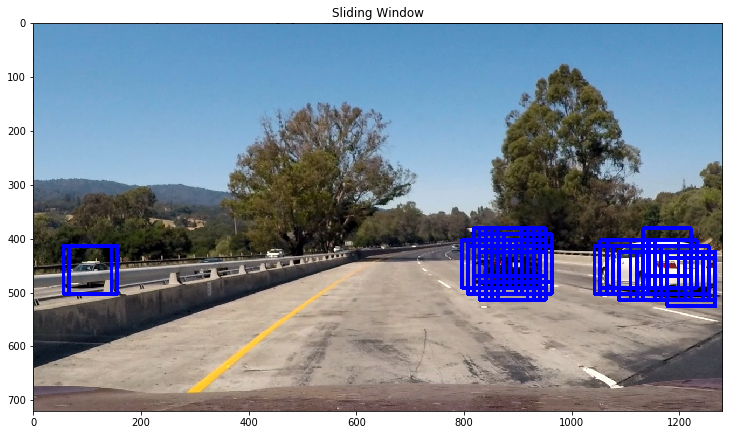

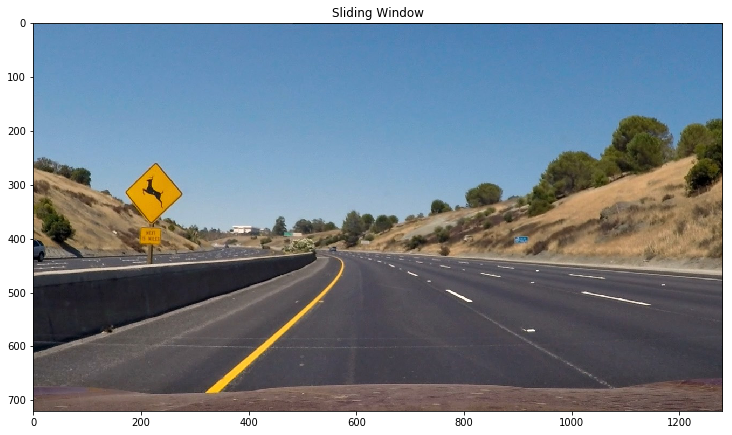

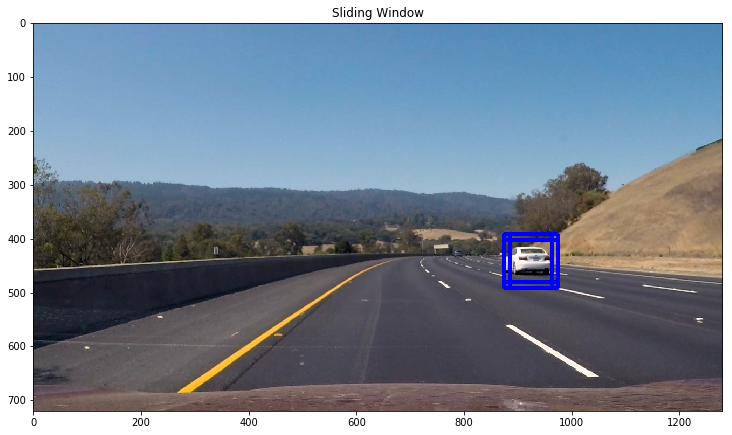

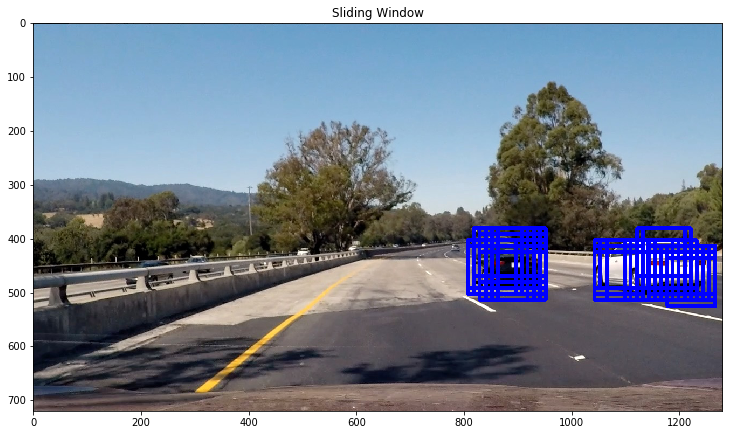

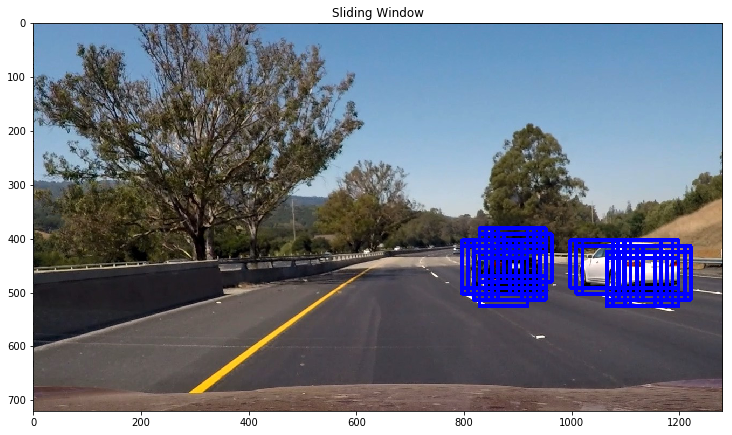

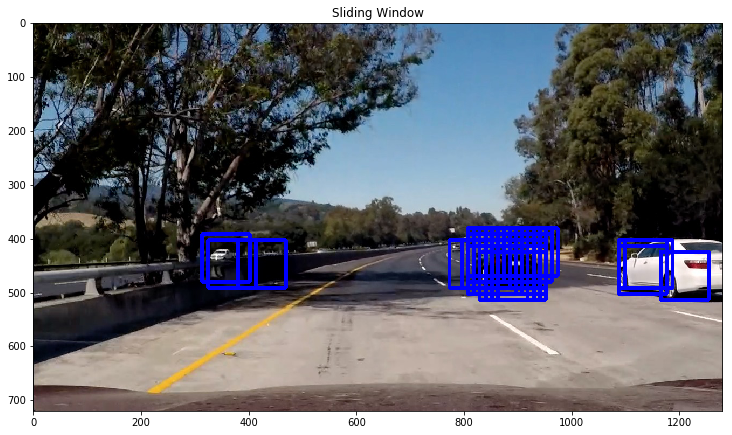

In [169]:
ystart = 380 #Y values for start of window search 
ystop = 650 #Y Values for end of window search
scale=1.4  #Scale Value
cells_per_step=1 #cells per step
test_files = glob.glob('test_images/test*.jpg')
for file in test_files:
    fileName=file.split("/")[1].split(".")[0]
    image = mpimg.imread(file)
    (boxes,out_img)=find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(out_img)
    plt.title('Sliding Window')
    plt.savefig('output_images/test_images_sliding_window_'+fileName+".png",dpi=200)
    fig.tight_layout()
    plt.show()

## Parallel Window Search Implementation

In [142]:
#This method is called by workers to run multiple HOG sub-sampling search in parallel 
def parallel_find_cars(a):
    image,scale_v,cells_per_step_v=a
    return find_cars(image, ystart, ystop, scale_v, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step_v)


## Pipeline method

In [153]:
#This takes image as input and outputs detected cars in the image
def process_image(image,returnHeatmap=False,isVideo=True):
    draw_image = np.copy(image)
    #Run Sub-sampling window search on different scale and cells_per_steps
    scale_values=[1.4,2]
    cells_per_steps=[1,2]
    box_list=[]
    args=[]
    for scale_v in scale_values:
        for cells_per_step_v in cells_per_steps:
            args.append((image,scale_v,cells_per_step_v))
    
    #Run in parallel and combine all the boxes
    for (boxes,out_img) in pool.imap_unordered(parallel_find_cars, args):
         box_list.extend(boxes)
    
    #Create heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)
   
    #Check if processing video
    if(isVideo==True):
        #Combine all heat values from  previous frames as given by numberOfFrames
        #previous_box_lists is a fixed length queue
        previous_box_lists.append(heat)
        if len(previous_box_lists)==numberOfFrames:
            heat_modified=sum(previous_box_lists)
            # Apply threshold equal to numberOfFrames to help remove false positives
            heat = apply_threshold(heat_modified,numberOfFrames)


    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #Reurn heatmap if asked for
    if(returnHeatmap):
        return (draw_img,heatmap)
    else:
        return draw_img

## Test on test images

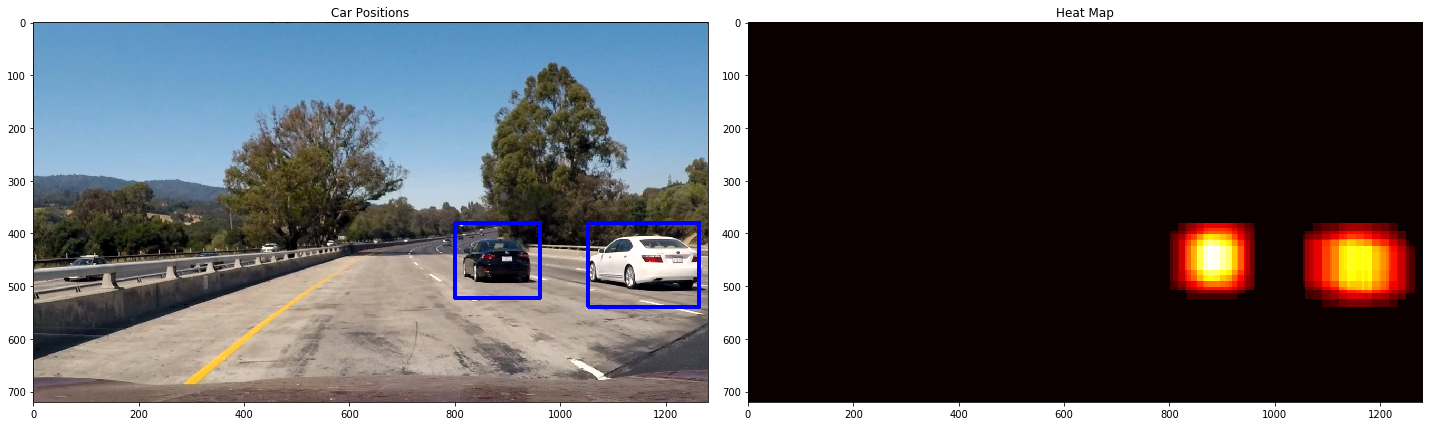

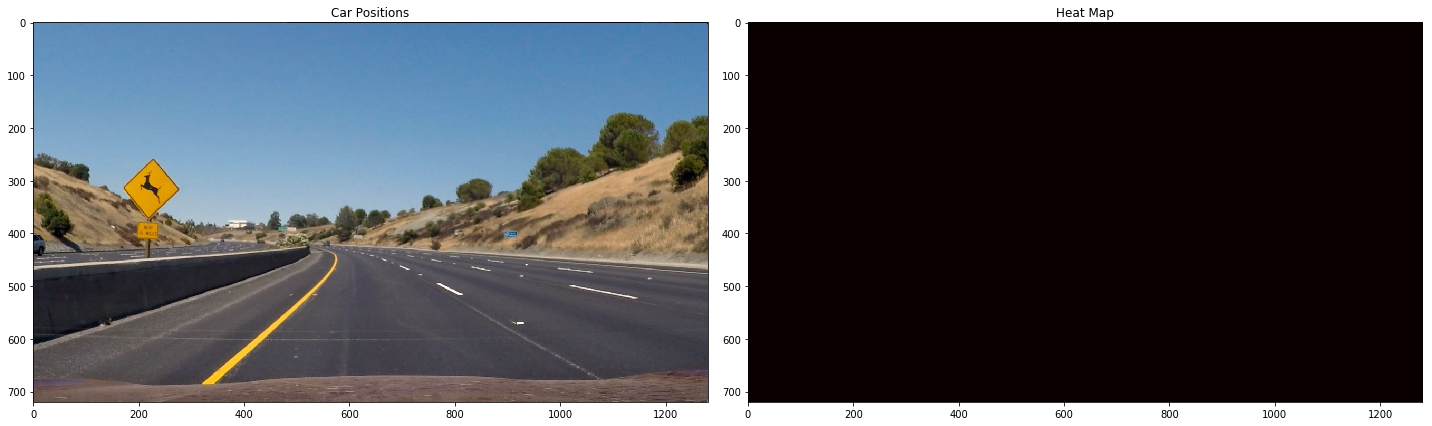

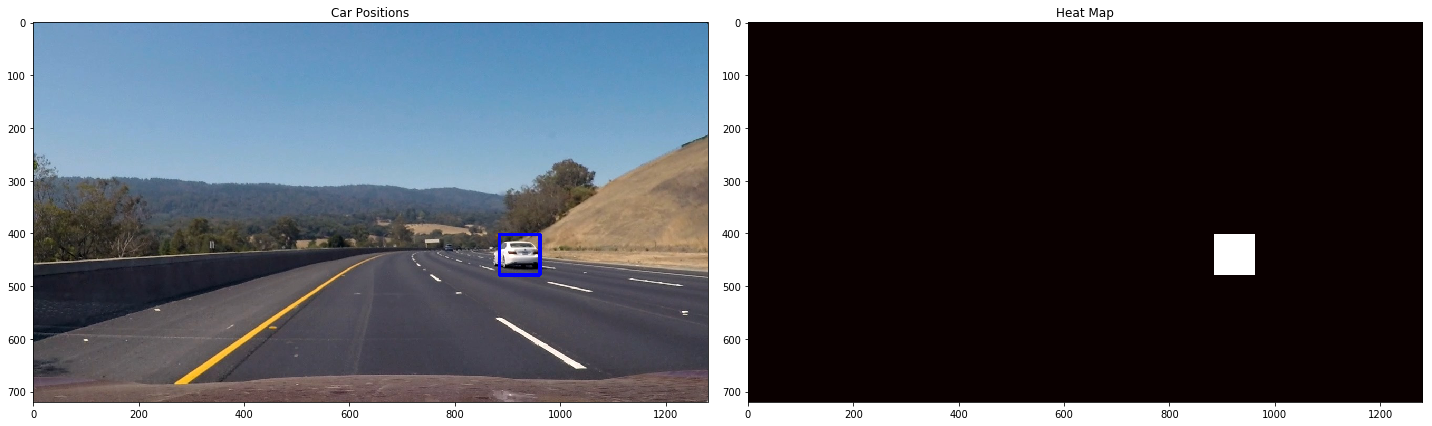

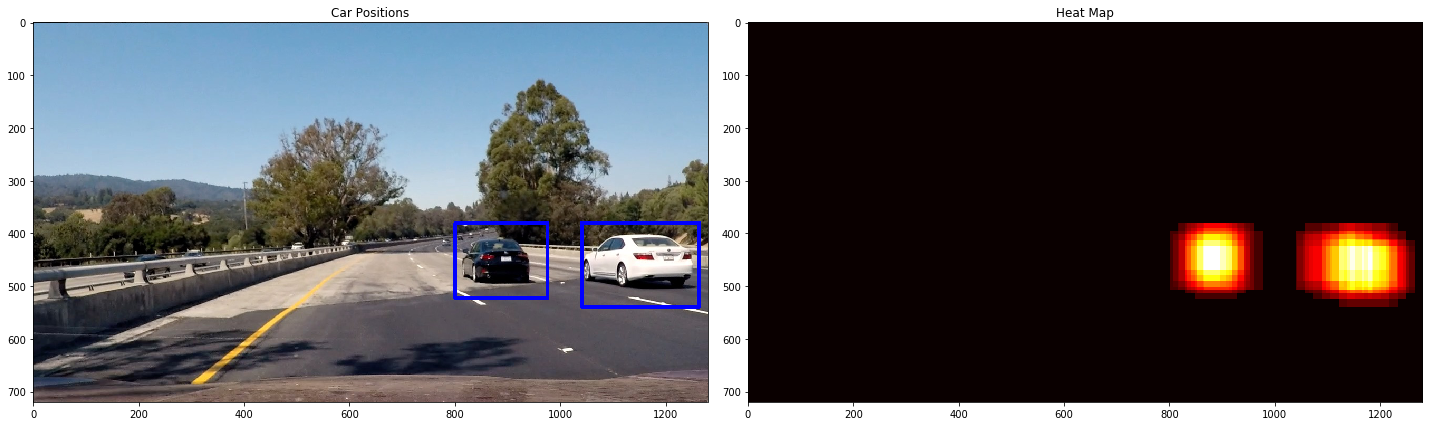

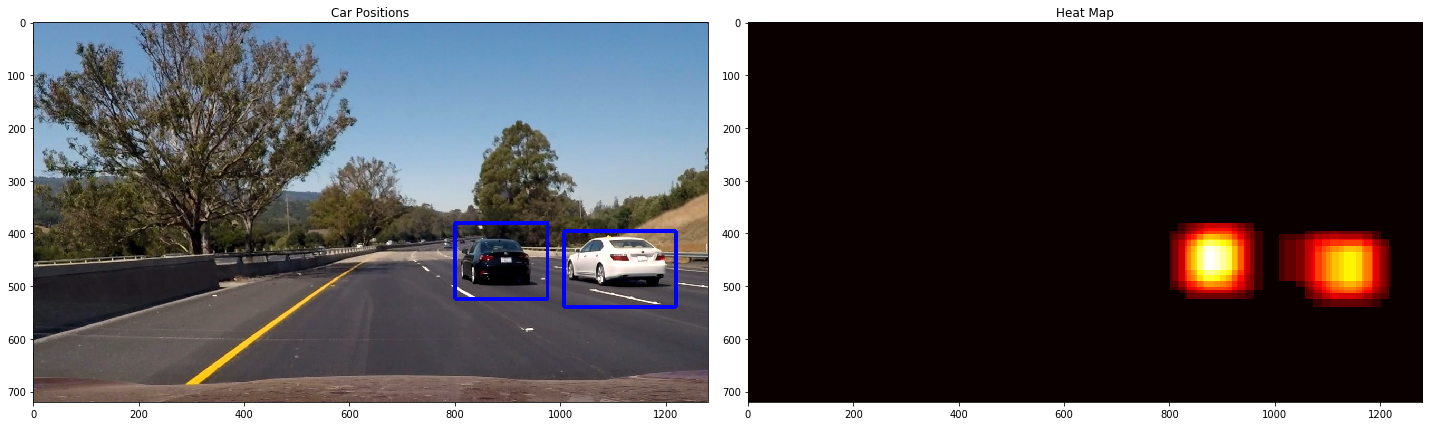

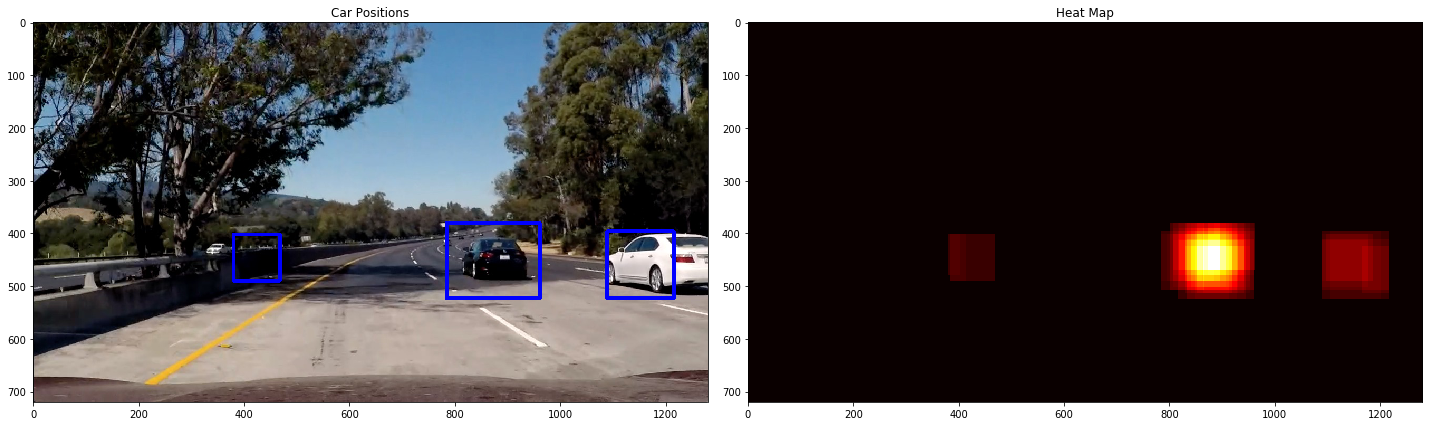

In [165]:
ystart = 380 #Y values for start of window search 
ystop = 650 #Y Values for end of window search
pool = Pool() #Thread pool
test_files = glob.glob('test_images/test*.jpg')
for file in test_files:
    fileName=file.split("/")[1].split(".")[0]
    image = mpimg.imread(file)
    (window_img,heatmap)=process_image(image,True,False)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.savefig('output_images/test_images_box_heatmap_'+fileName+".png",dpi=200)
    fig.tight_layout()
    plt.show()
pool.terminate()

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Test on test video

In [155]:
ystart = 380 #Y values for start of window search 
ystop = 650 #Y Values for end of window search
pool = Pool() #Thread pool
numberOfFrames=15 #Number of past video frames to smooth heatmap
previous_box_lists = deque([],maxlen=numberOfFrames) #Fixed length queue
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)
pool.terminate()

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:01<01:06,  1.74s/it]

  5%|▌         | 2/39 [00:03<01:02,  1.68s/it]

  8%|▊         | 3/39 [00:04<00:58,  1.63s/it]

 10%|█         | 4/39 [00:06<00:56,  1.60s/it]

 13%|█▎        | 5/39 [00:07<00:52,  1.55s/it]

 15%|█▌        | 6/39 [00:09<00:49,  1.50s/it]

 18%|█▊        | 7/39 [00:10<00:46,  1.46s/it]

 21%|██        | 8/39 [00:11<00:44,  1.45s/it]

 23%|██▎       | 9/39 [00:13<00:43,  1.46s/it]

 26%|██▌       | 10/39 [00:14<00:41,  1.42s/it]

 28%|██▊       | 11/39 [00:16<00:41,  1.47s/it]

 31%|███       | 12/39 [00:17<00:38,  1.44s/it]

 33%|███▎      | 13/39 [00:19<00:36,  1.42s/it]

 36%|███▌      | 14/39 [00:20<00:35,  1.41s/it]

 38%|███▊      | 15/39 [00:21<00:34,  1.42s/it]

 41%|████      | 16/39 [00:23<00:32,  1.41s/it]

 44%|████▎     | 17/39 [00:24<00:32,  1.47s/it]

 46%|████▌     | 18/39 [00:26<00:30,  1.43s/it]

 49%|████▊     | 19/39 [00:27<00:29,  1.47s/it]

 51%|█████▏    | 20/39 [00:29<00:27,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



## Run on project  video

In [156]:
ystart = 380 #Y values for start of window search 
ystop = 650 #Y Values for end of window search
pool = Pool() #Thread pool
numberOfFrames=15 #Number of past video frames to smooth heatmap
previous_box_lists = deque([],maxlen=numberOfFrames) #Fixed length queue
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)
pool.terminate()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<29:32,  1.41s/it]

  0%|          | 2/1261 [00:02<29:58,  1.43s/it]

  0%|          | 3/1261 [00:04<30:42,  1.46s/it]

  0%|          | 4/1261 [00:05<30:33,  1.46s/it]

  0%|          | 5/1261 [00:07<31:31,  1.51s/it]

  0%|          | 6/1261 [00:08<31:04,  1.49s/it]

  1%|          | 7/1261 [00:10<30:56,  1.48s/it]

  1%|          | 8/1261 [00:11<30:26,  1.46s/it]

  1%|          | 9/1261 [00:13<30:34,  1.46s/it]

  1%|          | 10/1261 [00:14<31:23,  1.51s/it]

  1%|          | 11/1261 [00:16<30:19,  1.46s/it]

  1%|          | 12/1261 [00:17<30:49,  1.48s/it]

  1%|          | 13/1261 [00:19<31:40,  1.52s/it]

  1%|          | 14/1261 [00:21<32:16,  1.55s/it]

  1%|          | 15/1261 [00:22<31:16,  1.51s/it]

  1%|▏         | 16/1261 [00:23<31:05,  1.50s/it]

  1%|▏         | 17/1261 [00:25<31:24,  1.52s/it]

  1%|▏         | 18/1261 [00:26<30:47,  1.49s/it]

  2%|▏         | 19/1261 [00:28<32:12,  1.56s/i

 11%|█▏        | 143/1261 [03:33<28:07,  1.51s/it]

 11%|█▏        | 144/1261 [03:35<28:08,  1.51s/it]

 11%|█▏        | 145/1261 [03:36<28:20,  1.52s/it]

 12%|█▏        | 146/1261 [03:38<28:21,  1.53s/it]

 12%|█▏        | 147/1261 [03:39<28:26,  1.53s/it]

 12%|█▏        | 148/1261 [03:41<28:00,  1.51s/it]

 12%|█▏        | 149/1261 [03:42<28:01,  1.51s/it]

 12%|█▏        | 150/1261 [03:44<28:28,  1.54s/it]

 12%|█▏        | 151/1261 [03:45<27:42,  1.50s/it]

 12%|█▏        | 152/1261 [03:47<28:20,  1.53s/it]

 12%|█▏        | 153/1261 [03:49<28:55,  1.57s/it]

 12%|█▏        | 154/1261 [03:50<27:34,  1.49s/it]

 12%|█▏        | 155/1261 [03:51<26:53,  1.46s/it]

 12%|█▏        | 156/1261 [03:53<26:56,  1.46s/it]

 12%|█▏        | 157/1261 [03:54<26:31,  1.44s/it]

 13%|█▎        | 158/1261 [03:56<27:26,  1.49s/it]

 13%|█▎        | 159/1261 [03:57<26:35,  1.45s/it]

 13%|█▎        | 160/1261 [03:59<25:49,  1.41s/it]

 13%|█▎        | 161/1261 [04:00<25:42,  1.40s/it]

 13%|█▎     

 23%|██▎       | 284/1261 [06:59<23:23,  1.44s/it]

 23%|██▎       | 285/1261 [07:01<24:09,  1.49s/it]

 23%|██▎       | 286/1261 [07:02<23:35,  1.45s/it]

 23%|██▎       | 287/1261 [07:04<24:06,  1.49s/it]

 23%|██▎       | 288/1261 [07:05<23:29,  1.45s/it]

 23%|██▎       | 289/1261 [07:07<22:57,  1.42s/it]

 23%|██▎       | 290/1261 [07:08<22:54,  1.42s/it]

 23%|██▎       | 291/1261 [07:10<22:57,  1.42s/it]

 23%|██▎       | 292/1261 [07:11<23:00,  1.42s/it]

 23%|██▎       | 293/1261 [07:13<23:50,  1.48s/it]

 23%|██▎       | 294/1261 [07:14<24:00,  1.49s/it]

 23%|██▎       | 295/1261 [07:15<23:11,  1.44s/it]

 23%|██▎       | 296/1261 [07:17<22:51,  1.42s/it]

 24%|██▎       | 297/1261 [07:18<22:19,  1.39s/it]

 24%|██▎       | 298/1261 [07:19<22:04,  1.38s/it]

 24%|██▎       | 299/1261 [07:21<22:03,  1.38s/it]

 24%|██▍       | 300/1261 [07:22<21:57,  1.37s/it]

 24%|██▍       | 301/1261 [07:24<22:03,  1.38s/it]

 24%|██▍       | 302/1261 [07:25<22:17,  1.39s/it]

 24%|██▍    

 34%|███▎      | 425/1261 [10:21<19:05,  1.37s/it]

 34%|███▍      | 426/1261 [10:22<18:55,  1.36s/it]

 34%|███▍      | 427/1261 [10:23<18:44,  1.35s/it]

 34%|███▍      | 428/1261 [10:25<19:34,  1.41s/it]

 34%|███▍      | 429/1261 [10:26<19:19,  1.39s/it]

 34%|███▍      | 430/1261 [10:27<18:57,  1.37s/it]

 34%|███▍      | 431/1261 [10:29<19:33,  1.41s/it]

 34%|███▍      | 432/1261 [10:30<19:07,  1.38s/it]

 34%|███▍      | 433/1261 [10:32<18:58,  1.38s/it]

 34%|███▍      | 434/1261 [10:33<18:54,  1.37s/it]

 34%|███▍      | 435/1261 [10:34<19:19,  1.40s/it]

 35%|███▍      | 436/1261 [10:36<18:56,  1.38s/it]

 35%|███▍      | 437/1261 [10:37<18:55,  1.38s/it]

 35%|███▍      | 438/1261 [10:39<19:50,  1.45s/it]

 35%|███▍      | 439/1261 [10:40<20:27,  1.49s/it]

 35%|███▍      | 440/1261 [10:42<20:02,  1.47s/it]

 35%|███▍      | 441/1261 [10:43<19:23,  1.42s/it]

 35%|███▌      | 442/1261 [10:45<20:03,  1.47s/it]

 35%|███▌      | 443/1261 [10:46<19:29,  1.43s/it]

 35%|███▌   

 45%|████▍     | 566/1261 [13:42<17:00,  1.47s/it]

 45%|████▍     | 567/1261 [13:43<17:35,  1.52s/it]

 45%|████▌     | 568/1261 [13:45<17:08,  1.48s/it]

 45%|████▌     | 569/1261 [13:46<17:01,  1.48s/it]

 45%|████▌     | 570/1261 [13:47<16:37,  1.44s/it]

 45%|████▌     | 571/1261 [13:49<17:01,  1.48s/it]

 45%|████▌     | 572/1261 [13:50<16:37,  1.45s/it]

 45%|████▌     | 573/1261 [13:52<16:22,  1.43s/it]

 46%|████▌     | 574/1261 [13:53<16:10,  1.41s/it]

 46%|████▌     | 575/1261 [13:54<15:56,  1.39s/it]

 46%|████▌     | 576/1261 [13:56<15:42,  1.38s/it]

 46%|████▌     | 577/1261 [13:57<15:54,  1.39s/it]

 46%|████▌     | 578/1261 [13:59<16:14,  1.43s/it]

 46%|████▌     | 579/1261 [14:00<15:47,  1.39s/it]

 46%|████▌     | 580/1261 [14:01<15:36,  1.38s/it]

 46%|████▌     | 581/1261 [14:03<15:46,  1.39s/it]

 46%|████▌     | 582/1261 [14:04<15:56,  1.41s/it]

 46%|████▌     | 583/1261 [14:06<15:58,  1.41s/it]

 46%|████▋     | 584/1261 [14:07<16:10,  1.43s/it]

 46%|████▋  

 56%|█████▌    | 707/1261 [17:05<13:30,  1.46s/it]

 56%|█████▌    | 708/1261 [17:06<13:19,  1.44s/it]

 56%|█████▌    | 709/1261 [17:08<13:32,  1.47s/it]

 56%|█████▋    | 710/1261 [17:09<13:19,  1.45s/it]

 56%|█████▋    | 711/1261 [17:11<12:59,  1.42s/it]

 56%|█████▋    | 712/1261 [17:12<13:14,  1.45s/it]

 57%|█████▋    | 713/1261 [17:14<13:30,  1.48s/it]

 57%|█████▋    | 714/1261 [17:15<13:28,  1.48s/it]

 57%|█████▋    | 715/1261 [17:17<13:47,  1.52s/it]

 57%|█████▋    | 716/1261 [17:18<13:47,  1.52s/it]

 57%|█████▋    | 717/1261 [17:20<13:32,  1.49s/it]

 57%|█████▋    | 718/1261 [17:21<13:50,  1.53s/it]

 57%|█████▋    | 719/1261 [17:23<13:23,  1.48s/it]

 57%|█████▋    | 720/1261 [17:24<13:06,  1.45s/it]

 57%|█████▋    | 721/1261 [17:25<12:43,  1.41s/it]

 57%|█████▋    | 722/1261 [17:27<12:39,  1.41s/it]

 57%|█████▋    | 723/1261 [17:28<13:02,  1.45s/it]

 57%|█████▋    | 724/1261 [17:30<12:37,  1.41s/it]

 57%|█████▋    | 725/1261 [17:31<13:11,  1.48s/it]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [20:30<09:42,  1.41s/it]

 67%|██████▋   | 849/1261 [20:31<10:06,  1.47s/it]

 67%|██████▋   | 850/1261 [20:33<09:50,  1.44s/it]

 67%|██████▋   | 851/1261 [20:34<09:38,  1.41s/it]

 68%|██████▊   | 852/1261 [20:35<09:35,  1.41s/it]

 68%|██████▊   | 853/1261 [20:37<09:26,  1.39s/it]

 68%|██████▊   | 854/1261 [20:38<09:53,  1.46s/it]

 68%|██████▊   | 855/1261 [20:40<09:43,  1.44s/it]

 68%|██████▊   | 856/1261 [20:41<10:07,  1.50s/it]

 68%|██████▊   | 857/1261 [20:43<09:43,  1.44s/it]

 68%|██████▊   | 858/1261 [20:44<09:42,  1.45s/it]

 68%|██████▊   | 859/1261 [20:45<09:34,  1.43s/it]

 68%|██████▊   | 860/1261 [20:47<09:42,  1.45s/it]

 68%|██████▊   | 861/1261 [20:48<09:31,  1.43s/it]

 68%|██████▊   | 862/1261 [20:50<09:21,  1.41s/it]

 68%|██████▊   | 863/1261 [20:51<09:13,  1.39s/it]

 69%|██████▊   | 864/1261 [20:52<09:10,  1.39s/it]

 69%|██████▊   | 865/1261 [20:54<09:08,  1.38s/it]

 69%|██████▊   | 866/1261 [20:55<09:06,  1.38s/it]

 69%|██████▉

 78%|███████▊  | 989/1261 [23:53<06:25,  1.42s/it]

 79%|███████▊  | 990/1261 [23:55<06:21,  1.41s/it]

 79%|███████▊  | 991/1261 [23:56<06:24,  1.43s/it]

 79%|███████▊  | 992/1261 [23:57<06:15,  1.40s/it]

 79%|███████▊  | 993/1261 [23:59<06:09,  1.38s/it]

 79%|███████▉  | 994/1261 [24:00<06:06,  1.37s/it]

 79%|███████▉  | 995/1261 [24:02<06:20,  1.43s/it]

 79%|███████▉  | 996/1261 [24:03<06:23,  1.45s/it]

 79%|███████▉  | 997/1261 [24:05<06:17,  1.43s/it]

 79%|███████▉  | 998/1261 [24:06<06:14,  1.43s/it]

 79%|███████▉  | 999/1261 [24:07<06:15,  1.43s/it]

 79%|███████▉  | 1000/1261 [24:09<06:06,  1.40s/it]

 79%|███████▉  | 1001/1261 [24:10<05:56,  1.37s/it]

 79%|███████▉  | 1002/1261 [24:12<06:01,  1.40s/it]

 80%|███████▉  | 1003/1261 [24:13<06:11,  1.44s/it]

 80%|███████▉  | 1004/1261 [24:15<06:27,  1.51s/it]

 80%|███████▉  | 1005/1261 [24:16<06:22,  1.49s/it]

 80%|███████▉  | 1006/1261 [24:18<06:31,  1.53s/it]

 80%|███████▉  | 1007/1261 [24:19<06:35,  1.56s/it]

 80%

 89%|████████▉ | 1128/1261 [27:14<03:11,  1.44s/it]

 90%|████████▉ | 1129/1261 [27:16<03:12,  1.46s/it]

 90%|████████▉ | 1130/1261 [27:17<03:17,  1.50s/it]

 90%|████████▉ | 1131/1261 [27:19<03:13,  1.49s/it]

 90%|████████▉ | 1132/1261 [27:20<03:06,  1.44s/it]

 90%|████████▉ | 1133/1261 [27:21<03:03,  1.43s/it]

 90%|████████▉ | 1134/1261 [27:23<03:06,  1.47s/it]

 90%|█████████ | 1135/1261 [27:24<03:00,  1.43s/it]

 90%|█████████ | 1136/1261 [27:26<02:59,  1.43s/it]

 90%|█████████ | 1137/1261 [27:27<03:04,  1.49s/it]

 90%|█████████ | 1138/1261 [27:29<02:57,  1.45s/it]

 90%|█████████ | 1139/1261 [27:30<02:53,  1.42s/it]

 90%|█████████ | 1140/1261 [27:32<02:54,  1.45s/it]

 90%|█████████ | 1141/1261 [27:33<02:50,  1.42s/it]

 91%|█████████ | 1142/1261 [27:34<02:45,  1.39s/it]

 91%|█████████ | 1143/1261 [27:36<02:42,  1.38s/it]

 91%|█████████ | 1144/1261 [27:37<02:46,  1.42s/it]

 91%|█████████ | 1145/1261 [27:39<02:41,  1.39s/it]

 91%|█████████ | 1146/1261 [27:40<02:39,  1.39

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.
Faced issues while choosing appropriate parameters for sliding window search and SVM. Also the pipeline runs very slow for a self driving car the pipeline need to be very fast.

#### 2. Where will your pipeline likely fail?
The pipeline at times detects vehicles in the opposite lane moving in opposite direction. This can cause the vehicle to take unnecessary evasive action.

#### 3. What could you do to make it more robust?

Tracking the direction of moving vehicles and filtering based on whether the vehicle is moving in the same direction in the lane or in opposite lane can help in reducing this issue.

Also pipeline speed need to be improved to be used in a self driving car.